<h1>Lab 06: Evolving Brains</h1>

<h2>CS371: Cognitive Science<br>
Bryn Mawr College, Fall 2016<br>
Prof. Blank
</h2>

This is a team-based project.

*Please put your "# title" and "## by-line" in the next two cells (respectively), and then delete this cell*

YOUR ANSWER HERE

YOUR ANSWER HERE

This lab explores using evolution to find a good Ladybug DNA. First, we have all of our imports and setup that we will need:

In [1]:
from calysto.simulation import DiscreteView, get_robot, DNARobot
from calysto.display import display, clear_output
import random
import string
import copy

%matplotlib inline

For these experiments, we will be using the DNA representation that is:

* exactly 93 characters long
* made up of the characters "0123456789"

Remember that exactly what these 93 bits of DNA are is unknown to us, as is the meaning of each character. We don't know how these DNA encode a Ladybug brain, but we know that somehow they do.

Our mission is to search through the space of possible Ladybug brains and find a good one, if not the best.

# Genetic Algorithm

Evolutionary algorithms are techniques for searching through a solution landscape in a generally effective manner. 

All evolutionary strategies have a core set of properties:

* A "population" of solutions
* Limited resources (not all solutions will survive)
* A measure of performance, called ''fitness''
* Preferential treatment toward the higher measured solutions (the most fit ones)
* Reliance on randomness

A typical evolutionary system follows this basic algorithm:

1. Create a random population of solutions
2. Compute a fitness measure for each
3. Create new members by mutating and/or combining old ones (often selecting the better ones based on fitness)
4. Select the most fit for the next generation
5. Go to Step #3



## Randomized DNA Function

First, we make a simple function to make a random DNA string:

In [2]:
alphabet = "0123456789"

def make_dna(length):
    return "".join([random.choice(alphabet) for i in range(length)])

In [3]:
dna = make_dna(93)
dna

'667725087231604835114936588685531632573346010361182621852439651692351185085263856981249486522'

## 1.2 Fitness Function

Let's let the ladybug move about for a few simulated seconds, or until it dies (whichever happens first). We'll take the fitness to be the average amount of energy that it has over that time.

To make this a bit easier on our ladybug, we'll add an extra cluster of food around it when we test the ladybug.

First, we make a simulation object and get the simulated ladybug:

In [4]:
sim = DiscreteView("Ladybug1")
robot = get_robot()

Nothing is visible, but it exists. This is to make the simulation run fast. Whenever we want, we can see where the ladybug is:

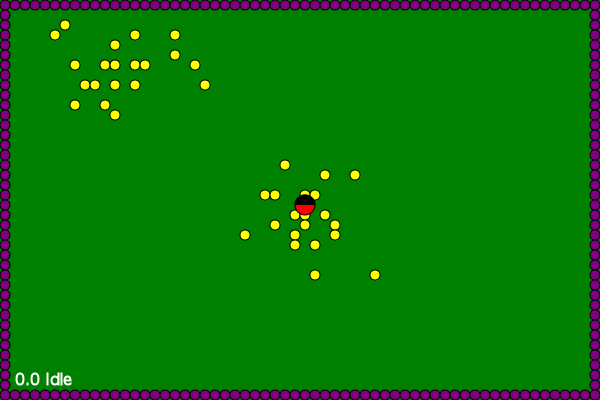

In [5]:
sim.render()

Now, we can define a fitness function. This is a little complicated, because we are using some of the internals of the simulation.

`compute_fitness()` does the following:

* takes a DNA string
* creates a DNARobot (ie, the ladybug) which needs the original robot, and 93 character DNA
* resets the simulation
* let's it run for some seconds, or until it dies
* computes the fitness avg energy over the run
* returns fitness

In [6]:
def compute_fitness(dna, seconds, show=False):
    new_robot = DNARobot(robot, dna)
    sim.setRobot(0, new_robot)
    sim.reset()
    while new_robot.energy > 0 and sim.clock < seconds:
        sim.step()
        if show:
            clear_output(wait=True)
            display(sim.render())
    fitness = sum(new_robot.history)/len(new_robot.history)
    return fitness

Now we try it:

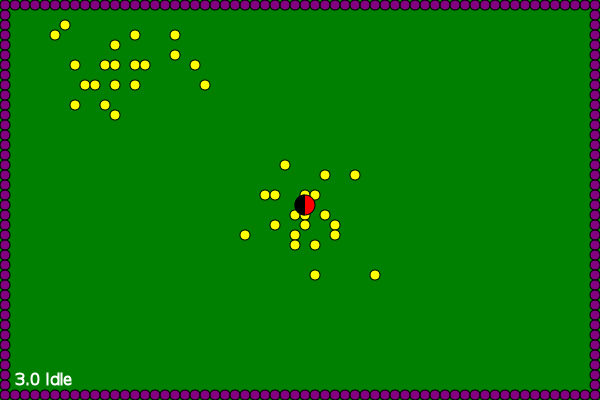

92.5
CPU times: user 2.85 s, sys: 14 ms, total: 2.87 s
Wall time: 3.11 s


In [7]:
%%time
dna = make_dna(93)
print(dna)
print(compute_fitness(dna, 3, True))

In [8]:
%%time
print(dna)
print(compute_fitness(dna, 3, False))

198996236972211213555226682775354052437519977701384932237059263031245677270529281530796359230
92.5
CPU times: user 552 ms, sys: 5 ms, total: 557 ms
Wall time: 799 ms


With the display on, it will take about the number of seconds run. Without the display, the actual time taken is less that seconds given.

## 1.3 A Mutate Function

For all of the search methods (besides Greedy search) we need a method of slightly changing the DNA. 

For some search algorithms, we will need a variable amount of mutation. So, we will make our `mutate` function take two arguments: the DNA to mutate, and an amount. The amount will be the number of mutations to make.

Write your mutate function here:

In [9]:
def mutate(dna, amount):
    dna_list = list(dna)
    ### BEGIN SOLUTION
    for i in range(amount):
        point = int(random.random() * len(dna))
        dna_list[point] = random.choice(alphabet)
    ### END SOLUTION
    return "".join(dna_list)

In [10]:
mutate("XXX", 1)

'1XX'

In [11]:
mutate(dna, 10)

'198206236932211213555226682775354052437519977771384932237052263031245677270529885530686359230'

## 1.4 Putting it altogether

We define a make_pop() function that will generate a number of DNA. We return them as a list of pairs:

```python
[[0, DNA1], [0, DNA2], ...]
```

The zero is a place keeper where we will put the fitness in a moment.

In [12]:
def make_pop(size, dna=None):
    pop = []
    for i in range(size):
        if dna is None:
            pop.append([0, make_dna(93)])
        else:
            pop.append([0, mutate(dna, 10)])
    return pop

In [13]:
pop = make_pop(3)
pop

[[0,
  '288011181125947895543144113760071612630986198389816490561083032835531858849961664286602626144'],
 [0,
  '535509792262951458600411106626311989962369722112135552266827753540524375199777013849322370592'],
 [0,
  '630312456772705292815307963592305019810338376558525912677696262144070735157945904944963440121']]

## How diverse is the population per position?

We define a simple function to show the diversity of the population. Along the top will be each position of the DNA. Along the left side is the possible values for a location (a gene). The matrix is filled with the counts of those genes in that location.

In [14]:
def show_diversity(pop):
    counts = [{} for i in range(len(pop[0][1]))]
    for i in range(len(pop)):
        for j in range(len(pop[i][1])):
            c = pop[i][1][j]
            counts[j][c] = counts[j].get(c, 0) + 1
    print("   012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012")
    print("   ---------------------------------------------------------------------------------------------")
    for number in range(9, -1, -1):
        print("%s: " % number, end="")
        for position in range(len(counts)):
            count = int(counts[position].get(str(number), 0)/len(pop) * 10)
            if count == 10:
                count = "X"
            elif count == 0:
                count = "."
            print(count, end="")
        print()

In [15]:
show_diversity(pop)

   012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012
   ---------------------------------------------------------------------------------------------
9: .....3.3....6...6.......3...3....3.63..3.3.3...3...33.....3..............366..3..3.33......3.
8: .33....3.......3.33...............3.3...33..3.333........33....3.....3.33........33..........
7: ......3..33.3.3........3...3...3..........33...........33..33......3.33...3333..........3....
6: 3.......3.3.......3......33333...3..33..33..3.....3...3633.3.3..............3.33...333.3.3...
5: 3.33...3...3.33.333.3......3....3............33.3.633.3......3.3.36...36.3...3............3..
4: ......3......3.3...3.333...........................3............63..3....3..3...6.63...33..33
3: .6.3................33....6...6......3.63.3..3...3.........3.33.3..3.33.........3...3.33.....
2: 3....3..3336...3.3..........33.....3..3....33..3.3...63...3.3.6....3.............3...36.3..33
1: ....633.33....3....3.33363.

In [16]:
for i in range(len(pop)):
    pop[i][0] = compute_fitness(pop[i][1], 3)

In [17]:
pop.sort(reverse=True)

In [18]:
pop

[[92.5,
  '630312456772705292815307963592305019810338376558525912677696262144070735157945904944963440121'],
 [92.5,
  '535509792262951458600411106626311989962369722112135552266827753540524375199777013849322370592'],
 [92.5,
  '288011181125947895543144113760071612630986198389816490561083032835531858849961664286602626144']]

## Crossover Function

Crossover exchanges pieces of two genomes. Crossover can be a perfect shuffle, uniform, or point-based. Shuffle simply alternates between each parent. Uniform tosses an even coin to see if the gene comes from the mother or the father. Point-based mutation will only crossover at particular points. Shown here is a single point crossover:

<img src="http://cs.brynmawr.edu/~dblank/images/crossover-transparent.gif"/>

To use crossover, we need a method of selecting good parents:

In [19]:
def select(pop):
    """
    Given a population of the form [[FITNESS, DNA], ...]
    pick one (with better fitness, more likily to be picked), 
    and return a copy of the DNA.
    """
    partsum = 0.0
    sumFitness = sum([item[0] for item in pop])
    if sumFitness == 0:
        raise Exception("Population has a total of zero fitness")
    spin = random.random() * sumFitness
    index = 0
    while index < len(pop) - 1:
        fitness = pop[index][0]
        if fitness < 0:
            raise Exception("Negative fitness in select: " + str(fitness))
        partsum += fitness
        if partsum >= spin:
            break
        index += 1
    #print("index:", index)
    return copy.copy(pop[index][1])

In [20]:
select(pop)

'630312456772705292815307963592305019810338376558525912677696262144070735157945904944963440121'

Our crossover function will replace a segment of the population, given by `percentage`:

In [21]:
def crossover(pop, percentage):
    """
    Given a population and a percentage, replace
    that percentage of the population with new
    individuals created from higher-fitness individual.
    New individuals replace the worst-performing individuals.
    """
    old_pop = copy.copy(pop)
    for j in range(int(len(pop) * percentage)):
        p1 = select(old_pop)
        p2 = select(old_pop)
        # Pick a crossover point:
        point = random.randint(0, len(pop[j][1]) - 1)
        child = []
        for i in range(len(pop[j][1])):
            if i < point:
                child.append(p1[i])
            else:
                child.append(p2[i])
        child = "".join(child)
        #print("p1:", p1)
        #print("p2:", p2)
        #print("c :", child)
        #print("replacing", len(pop) - j - 1)
        pop[len(pop) - j - 1][1] = child

In the following cell, provide settings for all of the parameters, such as:

```python
generations = 2
simulated_seconds = 3
pop_size = 10
mutations_per_individual = 10
crossover_percentage = .33
```

In [22]:
### BEGIN SOLUTION
generations = 10
simulated_seconds = 5
pop_size = 10
mutations_per_individual = 10
crossover_percentage = .33
### END SOLUTION

And then run the experiment!

In [23]:
best_fitness = []
pop = make_pop(pop_size)
for generation in range(generations):
    print("Computing fitness...")
    for i in range(len(pop)):
        pop[i][0] = compute_fitness(pop[i][1], simulated_seconds)
    print("Sorting...")
    pop.sort(reverse=True)
    print("Generation:", generation + 1, "Best:", pop[0][0])
    print("  Best DNA:", pop[0][1])
    print("Mutating...")
    best_fitness.append(pop[0][0])
    for i in range(2, len(pop)):
        pop[i][1] = mutate(pop[i][1], mutations_per_individual)
    # Crossover:
    crossover(pop, crossover_percentage)

Computing fitness...
Sorting...
Generation: 1 Best: 115.75
  Best DNA: 199777013849322370592630312456772705292815307963592305019810338376558525912677696262144070735
Mutating...
Computing fitness...
Sorting...
Generation: 2 Best: 115.75
  Best DNA: 199777013849322370592630312456772705292815307963592305019810338376558525912677696262144070735
Mutating...
Computing fitness...
Sorting...
Generation: 3 Best: 115.75
  Best DNA: 199777013849322370592630312456772705292815307963592305019810338376558525912677696262144070735
Mutating...
Computing fitness...
Sorting...
Generation: 4 Best: 115.75
  Best DNA: 199777013849322370592630312456772705292815307963592305019810338376558525912677696262144070735
Mutating...
Computing fitness...
Sorting...
Generation: 5 Best: 115.75
  Best DNA: 199777013849322370592630312456772705292815307963592305019810338376558525912677696262144070735
Mutating...
Computing fitness...
Sorting...
Generation: 6 Best: 115.75
  Best DNA: 19977701384932237059263031245677270529281530

## 1.5 Analysis

Now, you can examine different aspects of this evolutionary run.

In [24]:
pop

[[115.75,
  '199777013849322370592630312456772705292815307963592305019810338376558525912677696262144070735'],
 [106.44444444444444,
  '879961668136608656828582931173558626726394621678393989229862522413204340489912115921688388838'],
 [106.44444444444444,
  '179201668136608640828501600281522048866996064979382667781462401430204807460557865983683896836'],
 [106.44444444444444,
  '149201668136608640828512600281522048866996064979382667781462401414204427560857815270686702838'],
 [87.5,
  '879961668636608640828501600281522048866996064968382667781464401430204800460507869983183896836'],
 [87.5,
  '879961668636608640828501600281522048866996064968382667781464401430204800460507869983183896836'],
 [87.5,
  '879961668636608640828501600281522048866996064968382669781464401414204420560857815270196702836'],
 [87.5,
  '879961668636608640828501600281522048866996064968382669781464401414204420560857815270196702836'],
 [87.5,
  '879961668636608640828501600281522048866996064968382667781464401414204420560857815

What does the diversity of the population's DNA look like?

In [25]:
show_diversity(pop)

   012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012
   ---------------------------------------------------------------------------------------------
9: .1X6.......1.......1....1............1.89....9.2.2.1.4..2...............1.11...124...4..3....
8: 6.......91....9...9.9.1.....8...1..88..1.......7.8..1..8.2....1.....13...1.5..8...3..513119.2
7: .7.111..........1...........1.11.1..1.......1.3......58.........1......2....19....5....51.1..
6: ....6.99.5.99..9.1...1..8....1...1.1.89..818.17....88.....9......1.......8.1..131.1.3.5..3..7
5: ................1.1..9......1.91...1.....1......1....1......1.....11.1.15..36...7...........1
4: .2........1.....8..........1......8......1..8............8.68..9.5..951.4............11......
3: ........1.9.1..1......1.11...1.........1..1....19.11........11.131...1.............3..31...X.
2: ...3.........11....91..2..18...89.1.111....1......9...11...3.11...9...6...1..1...611.....5...
1: 4....9.1.4............17.11

In the following cell, discuss the diversity of the population. Is this what you expected? Did it "converge"? Or is the population fairly diverse?

YOUR ANSWER HERE

In the following cell, create a matplotlib graph of the best fitnesses over time.

In [26]:
best_fitness

[115.75,
 115.75,
 115.75,
 115.75,
 115.75,
 115.75,
 115.75,
 115.75,
 115.75,
 115.75]

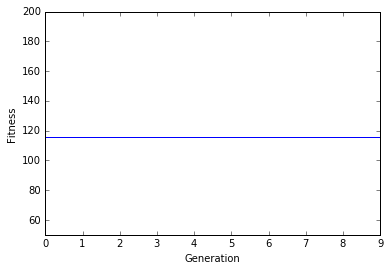

In [40]:
import matplotlib.pyplot as plt
### BEGIN SOLUTION
plt.plot(best_fitness)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.ylim(50,200)
plt.show()
### END SOLUTION

As part of any experiment, you'll want to examine different solutions. This section explores how you can watch a DNA control the ladybug, and make a movie for showing.

First, we define two functions:

In [31]:
def watch_one(dna, seconds=10):
    new_robot = DNARobot(robot, dna)
    sim.setRobot(0, new_robot)
    sim.reset()
    while new_robot.energy > 0 and sim.clock < seconds:
        sim.step()
        clear_output(wait=True)
        display(sim.render())
    print("fitness:", sum(new_robot.history)/len(new_robot.history))
    
def make_movie(dna, name, seconds=10):
    new_robot = DNARobot(robot, dna)
    sim.setRobot(0, new_robot)
    sim.reset()
    frame = 0
    while new_robot.energy > 0 and sim.clock < seconds:
        sim.step()
        canvas = sim.render()
        canvas.save("%s-%04d.gif" % (name, frame))
        frame += 1

`watch_one()` takes a DNA string, and simply renders it on each step:

In [32]:
dna = '900499520468472606914876192567498206996983559871961745555167134603951243523914525534679075336'

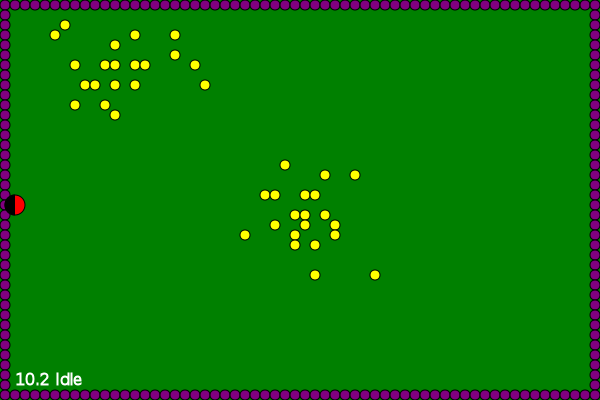

fitness: 74.5


In [33]:
watch_one(dna)

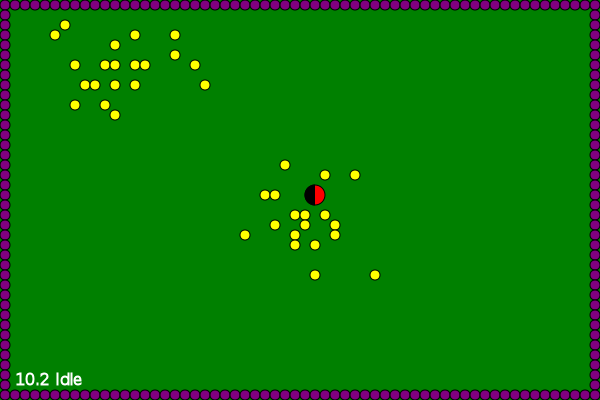

fitness: 108.88888888888889


In [34]:
watch_one(pop[0][1])

`make_movie()` takes a DNA string and a filename, and makes a bunch of gif files:

In [35]:
make_movie(pop[0][1], "ladybug-0")

You can turn the ladybug-0-\*.gif files into a movie named moview-0.gif with this shell command:

In [36]:
! convert -delay 20 -loop 0 ladybug-0-*.gif movie-0.gif

This cell is a markdown cell that shows how to display an animated gif file in your notebook using HTML:

<img src="movie-0.gif" />

Finally, you may want to delete the extra gif files with this shell command:

In [37]:
! rm ladybug-*.gif

## Team Reflection

In the next cell, add your reflections, including:

* What was your approach in picking parameters? Explain?
* What is the relationship between size of the population and diversity of the gene pool?
* What could make this evolution more realistic? What is missing?
* From what you know about ladybug control, what could this DNA be representing? Why 93?


YOUR ANSWER HERE